# PyTorch-based implementation for gene prediction using the Enformer architecture for coding (CDS) and non-coding region prediction

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install -q biopython

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 67.2 MB/s eta 0:00:00


## Step 2: Data Preprocessing
You need to parse `.fasta` for sequences and `.gff3` for annotations.

### Parsing GFF3 and FASTA

In [3]:
!cp -r /content/drive/MyDrive/Dalhousie/Dal.ML/Project/Final project/genomes.zip /content/extracted_genomes

cp: target '/content/extracted_genomes' is not a directory


In [4]:
!unzip /content/drive/MyDrive/Dalhousie/genomes.zip -d /content/extracted_genomes

Archive:  /content/drive/MyDrive/Dalhousie/genomes.zip
  inflating: /content/extracted_genomes/chlamydomonas_reinhartii.fasta  
  inflating: /content/extracted_genomes/chlamydomonas_reinhartii.gff3  
  inflating: /content/extracted_genomes/dictyostelium_discodeum.fasta  
  inflating: /content/extracted_genomes/dictyostelium_discodeum.gff3  
  inflating: /content/extracted_genomes/emiliana_huxleyi.fasta  
  inflating: /content/extracted_genomes/emiliana_huxleyi.gff3  
  inflating: /content/extracted_genomes/guillardia_theta.fasta  
  inflating: /content/extracted_genomes/guillardia_theta.gff3  
  inflating: /content/extracted_genomes/leishmania_major.fasta  
  inflating: /content/extracted_genomes/leishmania_major.gff3  
  inflating: /content/extracted_genomes/plasmodium_falciparum.fasta  
  inflating: /content/extracted_genomes/plasmodium_falciparum.gff3  
  inflating: /content/extracted_genomes/saccharomyces_cerevisiae.fasta  
  inflating: /content/extracted_genomes/saccharomyces_cere

In [5]:

from Bio import SeqIO
import pandas as pd

def parse_gff3(gff3_file):
    data = []
    with open(gff3_file, 'r') as file:
        for line in file:
            if line.startswith("#"):
                continue
            fields = line.strip().split('\t')
            if len(fields) == 9:  # Ensure valid GFF3 format
                data.append({
                    'seq_id': fields[0],
                    'source': fields[1],
                    'type': fields[2],
                    'start': int(fields[3]),
                    'end': int(fields[4]),
                    'score': fields[5],
                    'strand': fields[6],
                    'phase': fields[7],
                    'attributes': fields[8],
                })
    return pd.DataFrame(data)

def parse_fasta(fasta_file):
    sequences = {}
    for record in SeqIO.parse(fasta_file, "fasta"):
        sequences[record.id] = str(record.seq)
    return sequences

# Example
# gff3_file = "data/extracted_genomes/merged.gff3"
# fasta_file = "data/extracted_genomes/merged.fasta"

gff3_file = "./extracted_genomes/plasmodium_falciparum.gff3"
fasta_file = "./extracted_genomes/plasmodium_falciparum.fasta"

gff3_df = parse_gff3(gff3_file)
sequences = parse_fasta(fasta_file)

In [6]:
gff3_df['type'].unique()

array(['region', 'gene', 'CDS', 'pseudogene', 'ncRNA', 'exon', 'rRNA',
       'snoRNA', 'tRNA', 'snRNA'], dtype=object)

In [7]:
gff3_df['seq_id'].unique()

array(['AL844501.2', 'LN999943.1', 'AL844502.2', 'AL844503.2',
       'AL844504.2', 'AL844505.2', 'AL844506.3', 'AL844507.3',
       'AL844508.2', 'LN999944.1', 'LN999945.1', 'LN999947.1',
       'AL844509.3', 'LN999946.1', 'LR605957.1', 'LR605956.1'],
      dtype=object)

In [8]:
sequences.keys()

dict_keys(['AL844501.2', 'LN999943.1', 'AL844502.2', 'AL844503.2', 'AL844504.2', 'AL844505.2', 'AL844506.3', 'AL844507.3', 'AL844508.2', 'LN999944.1', 'LN999945.1', 'LN999947.1', 'AL844509.3', 'LN999946.1', 'LR605957.1', 'LR605956.1'])

In [9]:
len(gff3_df), len(sequences)

(21638, 16)

In [10]:
gff3_df.head()

,seq_id,source,type,start,end,score,strand,phase,attributes
0,AL844501.2,EMBL,region,1,640851,.,+,.,ID=AL844501.2:1..640851;Dbxref=taxon:36329;Nam...
1,AL844501.2,EMBL,gene,29510,37126,.,+,.,ID=gene-PF3D7_0100100;Name=PF3D7_0100100;gbkey...
2,AL844501.2,EMBL,CDS,29510,34762,.,+,0,ID=cds-CAB89209.1;Parent=gene-PF3D7_0100100;Db...
3,AL844501.2,EMBL,CDS,35888,37126,.,+,0,ID=cds-CAB89209.1;Parent=gene-PF3D7_0100100;Db...
4,AL844501.2,EMBL,gene,38982,40207,.,-,.,ID=gene-PF3D7_0100200;Name=PF3D7_0100200;gbkey...


In [11]:
sequences['AL844503.2']

'aaccctaaaccctgaaccctaaaccctaaaccctgaaccctgaaccctaaaccctaaaccctaaaacctgaaccctaaaccctaaaccctgaaccctgaaccctaaaccctaaaccctaaacctaaaccctgaaccctaaaccctaaaccctaaaccctgaaccctaaaccctgaaccctaaaccctgaaccctaaaccctaaaccctaaaccctaaaccctaaaccctaaaccctgaaccctaaaccctaaaccctaaacccacaccctaaacctaaaccctgaaccctaaaccctaaaccctgaacccgaaccctaaaccctaaaccctaaaccctaaaccctaaaacctaaaccctgaaaccctaaaccctaaaccctaaaccctaaaccctgaaccctaaaccctaaaccctgaaccctaaaaccctgaaccctgaacctaaacctaaaccctgaaccctaaacccttgaaccctaaaccctaaaccttaGTCTTAATTTCTTATTCTTAGGTCCTTAGTCTTAATTTCTTATTCTTAGGTCCTTATTCTTACTTTCTTGTTCTTAGGTCCTTAgtcttacttacttactcttatcttcttacttttcattccttactcttacttacttactcttactttcttcttacttttcattccttactcttacgtccttactcttacttacttactcttatcttcttacttttcatttcttagtcttatcttcttactcttacttacttactcttatgttcttacttttcatttcttagtcttactttcttcttcttaggaccttacttttcatttcttaaTCATATATTCATACTCATATAGTTCTTGACTTAACTTTTTATTCTTACTTACTTAGtcttatattctttttatcatGTTCAAGGTCTTATTTCTTAAATACTAGGTCCTTAATCTCATAATTCTACTCTTAATTTCTTACTTCTACGTCCTTATTCTTACTTTCTTCATCTTACATCCT

In [12]:
len(sequences['AL844503.2'])

1200490

### Generating Training Samples
Create sliding windows from the genome sequences and assign labels based on gff3.

In [29]:
import numpy as np
from tqdm import tqdm

def generate_samples(sequences, gff3_df, window_size=1000):
    features = []
    labels = []

    # Wrap the outer loop with tqdm to monitor progress
    for seq_id, sequence in tqdm(sequences.items(), desc="Processing sequences", unit="sequence"):
        sequence_length = len(sequence)
        annotation = gff3_df[gff3_df['seq_id'] == seq_id]

        # Wrap the inner loop with tqdm to monitor window progress for each sequence
        for start in tqdm(range(0, sequence_length - window_size + 1, window_size), desc=f"Processing windows for {seq_id}", leave=False, unit="window"):
            end = start + window_size
            subseq = sequence[start:end]

            # Binary label: coding (1) or non-coding (0)
            label = any(
                (annotation['start'] <= end) & (annotation['end'] >= start) &
                (annotation['type'].isin(['CDS', 'gene','exon']))
            )
            features.append(subseq)
            labels.append(int(label))

    return features, labels

window_size = 1000
features, labels = generate_samples(sequences, gff3_df, window_size=window_size)

Processing windows for LR605957.1:   0%|          | 0/5 [00:00<?, ?window/s]
                                                                            
Processing sequences: 100%|██████████| 16/16 [00:19<00:00,  1.24s/sequence]


In [30]:
len(features), len(labels)

(23324, 23324)

In [31]:
features[0]

'TGAACCCTaaaacctaaaccctaaaccctaaaccctgaaccctaaaccctgaaccctaaaccctaaaccctgaaccctaaaccctaaaccctgaaccctaaaccctgaaacctaaaccctgaaccctaaaccctgaaccctgaaccctaaccctaaaccctaaacctaaaaccctgaaccctaaaccctgaaccctgaaccctaaaccctgaaccctaaaccctaaaccctgaaccctaaaccctgaaccctaaaccctaaaccctgaaccctgaaccctaaaacctaaaccctaaaccctaaaccctaaaccctgaacctaAACCTAAAACCTAAAACCtaaaaccctgaacccttacttttcatttcttcttcttatcttcttacttttcattctttactcttacttacttagtcttacttacttactcttacttacttactcttatcttcttacttttcatttcttagtcttacttacttactcttacttacttactcttatcttcttacttttcattccttactcttacttacttactgttatcttcttacttttcattccttactcttacttacttactcttacttacttactcttacttacttactcttatcttcttacttttcattccttactcttacttacttactcttacttacttactcttatcttcttacttttcattccttacttttcatttcttagtcttacttacttactcttacttacttactcttacttacttactcttactttcttcttcttatcttcttactgttatcttcttacttttcattccttactcttacttacttactcttatcttcttacttttcattccttactcttacttacttactcttatcttcttacttttcattccttactcttacttacttactcttatcttcttacttttcattccttactcttacttacttactcttacttacttactcttacttacttactgttatcttcttacttttcattcc

In [32]:
labels[0]

0

### Encoding DNA Sequences
DNA sequences are encoded into a numerical format for the model.

In [33]:
def encode_sequence(sequence):
    encoding = {'A': 0, 'C': 1, 'G': 2, 'T': 3, 'N': 4}
    return [encoding.get(base, 4) for base in sequence]

encoded_features = [encode_sequence(seq) for seq in features]

## Step 3: Transformer Model Architecture
Enformer is a transformer-based model for DNA sequences. Below is a simplified PyTorch implementation.

In [34]:
import torch
import torch.nn as nn

class GenePredictionModel(nn.Module):
    def __init__(self, input_length, num_classes, embed_dim=256, num_heads=4, num_layers=4):
        super(GenePredictionModel, self).__init__()
        self.embedding = nn.Embedding(5, embed_dim)  # A, C, G, T, N

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dim_feedforward=embed_dim * 4,
            activation='relu',
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.fc = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        x = self.embedding(x).permute(1, 0, 2)  # Sequence-first for transformer
        x = self.transformer(x)
        x = x.mean(dim=0)  # Global average pooling
        x = self.fc(x)
        return x

## Step 4: Training and Validation Functions

In [35]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score

def train_one_epoch(model, optimizer, criterion, dataloader, device):
    model.train()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    # for DataLoader with tqdm
    for batch in tqdm(dataloader, desc="Training", unit="batch"):
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        all_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    return running_loss / len(dataloader), acc

def validate(model, criterion, dataloader, device):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    # for DataLoader with tqdm
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Validation", unit="batch"):
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            all_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    return running_loss / len(dataloader), acc

## Step 5: DataLoader and Training Script

In [36]:
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split

class DNASequenceDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = [torch.tensor(seq, dtype=torch.long) for seq in sequences]
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]

In [37]:
len(encoded_features), len(labels)

(23324, 23324)

In [38]:
# Split data into train (80%) and temp (20% for validation + test)
X_train, X_temp, y_train, y_temp = train_test_split(encoded_features, labels, test_size=0.2, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Prepare datasets
train_dataset = DNASequenceDataset(X_train, y_train)
val_dataset = DNASequenceDataset(X_val, y_val)
test_dataset = DNASequenceDataset(X_test, y_test)

# Prepare dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Training script
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GenePredictionModel(input_length=window_size, num_classes=2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


#### Note: Choosing a Data Subset in the Absence of GPU Resources
- Code to Create Mini-Loader

In [39]:
from torch.utils.data import Subset

def create_mini_loader(dataset, subset_size, batch_size=32, shuffle=True):

    subset_indices = torch.randperm(len(dataset))[:subset_size]
    subset = Subset(dataset, subset_indices)

    # Create a DataLoader for the subset
    mini_loader = DataLoader(subset, batch_size=batch_size, shuffle=shuffle)
    return mini_loader

In [40]:
# Create mini-loaders for training and validation subsets
mini_train_loader = create_mini_loader(train_dataset, subset_size=100, batch_size=16, shuffle=True)
mini_val_loader = create_mini_loader(val_dataset, subset_size=50, batch_size=16, shuffle=False)
mini_test_loader = create_mini_loader(test_dataset, subset_size=50, batch_size=16, shuffle=False)

# Check the number of batches in the mini-loaders
print(f"Mini train loader batches: {len(mini_train_loader)}")
print(f"Mini val loader batches: {len(mini_val_loader)}")
print(f"Mini Test loader batches: {len(mini_test_loader)}")

# Example training loop using mini-loader
for batch in mini_train_loader:
    inputs, labels = batch
    print("Inputs shape:", inputs.shape)
    print("Labels shape:", labels.shape)
    break

Mini train loader batches: 7
Mini val loader batches: 4
Mini Test loader batches: 4
Inputs shape: torch.Size([16, 1000])
Labels shape: torch.Size([16])


In [41]:
epochs = 10
for epoch in range(epochs):
    train_loss, train_acc = train_one_epoch(model, optimizer, criterion, mini_train_loader, device)
    val_loss, val_acc = validate(model, criterion, mini_val_loader, device)
    print(f"Epoch {epoch+1}/{epochs}: Train Loss: {train_loss:.3f}, Train Acc: {train_acc:.3f}, Val Loss: {val_loss:.3f}, Val Acc: {val_acc:.3f}")

Validation: 100%|██████████| 4/4 [00:00<00:00, 23.61batch/s]


Epoch 1/10: Train Loss: 0.924, Train Acc: 0.800, Val Loss: 0.353, Val Acc: 0.860


Validation: 100%|██████████| 4/4 [00:00<00:00, 23.34batch/s]


Epoch 2/10: Train Loss: 0.451, Train Acc: 0.830, Val Loss: 0.359, Val Acc: 0.860


Validation: 100%|██████████| 4/4 [00:00<00:00, 23.45batch/s]


Epoch 3/10: Train Loss: 0.485, Train Acc: 0.830, Val Loss: 0.365, Val Acc: 0.860


Validation: 100%|██████████| 4/4 [00:00<00:00, 23.67batch/s]


Epoch 4/10: Train Loss: 0.441, Train Acc: 0.830, Val Loss: 0.346, Val Acc: 0.860


Validation: 100%|██████████| 4/4 [00:00<00:00, 23.72batch/s]


Epoch 5/10: Train Loss: 0.467, Train Acc: 0.830, Val Loss: 0.351, Val Acc: 0.860


Validation: 100%|██████████| 4/4 [00:00<00:00, 23.59batch/s]


Epoch 6/10: Train Loss: 0.451, Train Acc: 0.830, Val Loss: 0.351, Val Acc: 0.860


Validation: 100%|██████████| 4/4 [00:00<00:00, 23.47batch/s]


Epoch 7/10: Train Loss: 0.516, Train Acc: 0.830, Val Loss: 0.345, Val Acc: 0.860


Validation: 100%|██████████| 4/4 [00:00<00:00, 23.09batch/s]


Epoch 8/10: Train Loss: 0.484, Train Acc: 0.830, Val Loss: 0.404, Val Acc: 0.860


Validation: 100%|██████████| 4/4 [00:00<00:00, 23.48batch/s]


Epoch 9/10: Train Loss: 0.487, Train Acc: 0.830, Val Loss: 0.347, Val Acc: 0.860


Validation: 100%|██████████| 4/4 [00:00<00:00, 23.09batch/s]

Epoch 10/10: Train Loss: 0.470, Train Acc: 0.830, Val Loss: 0.377, Val Acc: 0.860


### For all data training

In [ ]:
# epochs = 10
# for epoch in range(epochs):
#     train_loss, train_acc = train_one_epoch(model, optimizer, criterion, train_loader, device)
#     val_loss, val_acc = validate(model, criterion, val_loader, device)
#     print(f"Epoch {epoch+1}/{epochs}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

## Step 6: Metrics and Final Evaluation
### Metrics Implementation
We use sklearn.metrics to compute metrics such as accuracy, precision, recall, and F1-score. These metrics are critical for understanding the performance of the gene prediction model.

In [42]:
from sklearn.metrics import classification_report, confusion_matrix

def compute_metrics(y_true, y_pred):
    """
    Compute and display classification metrics.
    """
    report = classification_report(y_true, y_pred, target_names=["Non-coding", "Coding"])
    print("\nClassification Report:")
    print(report)

    cm = confusion_matrix(y_true, y_pred)
    print("\nConfusion Matrix:")
    print(cm)

    return report, cm

### Final Evaluation Script
After training, you can use the following script to evaluate your model on a test dataset.

In [43]:
# Split data into train, validation, and test sets
# X_train, X_temp, y_train, y_temp = train_test_split(encoded_features, labels, test_size=0.3, random_state=42)
# X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Prepare datasets and dataloaders
# test_dataset = DNASequenceDataset(X_test, y_test)
# test_loader = DataLoader(test_dataset, batch_size=32)

mini_test_loader = create_mini_loader(test_dataset, subset_size=50, batch_size=16, shuffle=False)

# Evaluate on test set
def evaluate_on_test(model, test_loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_labels, all_preds

# Compute predictions
y_true, y_pred = evaluate_on_test(model, mini_test_loader, device)

# Compute and display metrics
compute_metrics(y_true, y_pred)


Classification Report:
              precision    recall  f1-score   support

  Non-coding       0.00      0.00      0.00         7
      Coding       0.86      1.00      0.92        43

    accuracy                           0.86        50
   macro avg       0.43      0.50      0.46        50
weighted avg       0.74      0.86      0.80        50


Confusion Matrix:
[[ 0  7]
 [ 0 43]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


('              precision    recall  f1-score   support\n\n  Non-coding       0.00      0.00      0.00         7\n      Coding       0.86      1.00      0.92        43\n\n    accuracy                           0.86        50\n   macro avg       0.43      0.50      0.46        50\nweighted avg       0.74      0.86      0.80        50\n',
 array([[ 0,  7],
        [ 0, 43]]))

## Saving and Loading the Model
It’s essential to save your trained model for reuse or inference. You can also load a saved model for evaluation.

In [44]:
# Save the trained model
torch.save(model.state_dict(), "enformer_gene_prediction.pth")

# Load the trained model
model = GenePredictionModel(input_length=window_size, num_classes=2)
model.load_state_dict(torch.load("enformer_gene_prediction.pth"))
model.to(device)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
<ipython-input-44-ebe2227ea7ef>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you sta

GenePredictionModel(
  (embedding): Embedding(5, 256)
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
        (linear1): Linear(in_features=256, out_features=1024, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=1024, out_features=256, bias=True)
        (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (fc): Linear(in_features=256, out_features=2, bias=True)
)

### Step 6-1: Visualizing the Results
Visualizations can help better understand model performance.

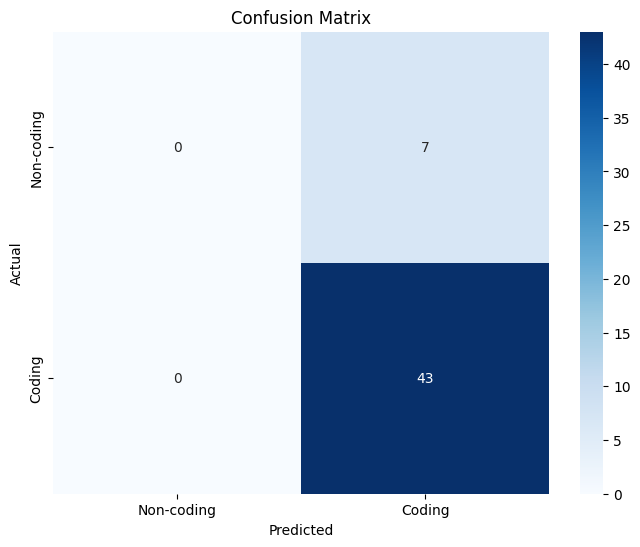

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot confusion matrix
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()

# Visualize the confusion matrix
class_names = ["Non-coding", "Coding"]
plot_confusion_matrix(confusion_matrix(y_true, y_pred), class_names)

### Step 6.2: Adding Precision-Recall Curve
The precision-recall curve provides additional insights, especially for imbalanced datasets.

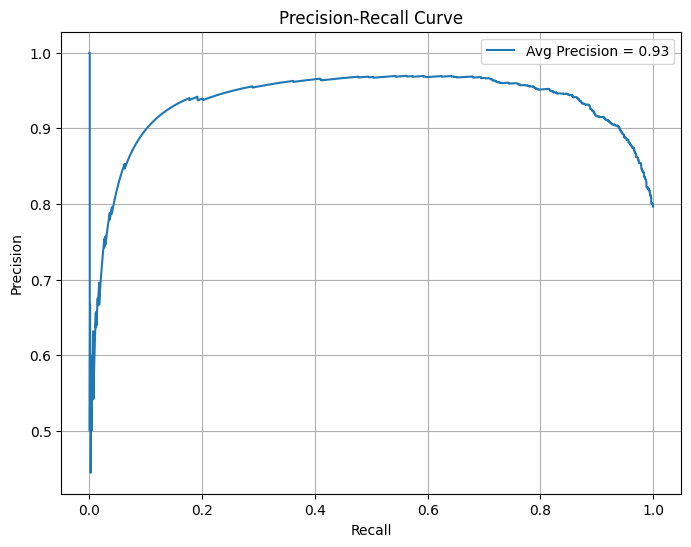

In [47]:
from sklearn.metrics import precision_recall_curve, average_precision_score

def plot_precision_recall(y_true, y_scores):
    precision, recall, _ = precision_recall_curve(y_true, y_scores[:, 1])  # Assuming class 1 is coding
    avg_precision = average_precision_score(y_true, y_scores[:, 1])

    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, label=f"Avg Precision = {avg_precision:.2f}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend()
    plt.grid()
    plt.show()

# Get raw scores for the test set
def get_scores(model, test_loader, device):
    model.eval()
    all_scores = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            all_scores.extend(outputs.cpu().numpy())
            all_labels.extend(labels.numpy())

    return np.array(all_labels), np.array(all_scores)

# Compute and plot precision-recall curve
y_true, y_scores = get_scores(model, test_loader, device)
plot_precision_recall(y_true, y_scores)